In [3]:
import pickle
ticker_timeseries = pickle.load(open("cache/ticker_timeseries.pkl", "rb"))

# Baseline with Vol

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# ---------- params ----------
lookback_window = 4
stock = 'PFE'
eps = 1e-8  # to avoid log(0)
cutoff = True  # whether to cutoff pre-pandemic data

# ---------- data ----------
# raw levels (T, 2)
si_dates = ticker_timeseries[stock]['SI'].dropna().index
SI_series = ticker_timeseries[stock]['SI'].dropna().values.astype(np.float64).reshape(-1, 1)
vol_series = ticker_timeseries[stock]['Volume'].dropna().values.astype(np.float64).reshape(-1, 1)

if cutoff:
    SI_series = ticker_timeseries[stock]['SI'][si_dates>pd.to_datetime('20220301')].dropna().values.astype(np.float64).reshape(-1, 1)
    vol_series = ticker_timeseries[stock]['Volume'][si_dates>pd.to_datetime('20220301')].dropna().values.astype(np.float64).reshape(-1, 1)
    si_dates = si_dates[si_dates>pd.to_datetime('20220301')]

level_series = np.concatenate([SI_series, vol_series], axis=1)  # (T, 2)

# log of SI levels (T,) for the target
series_safe = np.where(SI_series <= 0, eps, SI_series).reshape(-1)
y_log = np.log(series_safe)

# build supervised windows with log-return target
def make_windows_level_to_logret(level_series, y_log, lookback):
    X_list, y_logret_list, prev_log_list = [], [], []
    for t in range(lookback, len(level_series)):
        X_list.append(level_series[t - lookback:t, :])                  # (L, 2)
        y_logret_list.append([y_log[t] - y_log[t - 1]])                 # (1,)
        prev_log_list.append(y_log[t - 1])   
    X = np.asarray(X_list)                          # (N, L, 2)
    y_logret = np.asarray(y_logret_list)            # (N, 1)
    prev_log = np.asarray(prev_log_list)            # (N,)
    return X, y_logret, prev_log

X_raw, y_logret, prev_log_all = make_windows_level_to_logret(level_series, y_log, lookback_window)

# ---------- split ----------
N = X_raw.shape[0]
split = int(0.8 * N)
X_train_raw, X_test_raw = X_raw[:split], X_raw[split:]
y_train, y_test = y_logret[:split], y_logret[split:]
prev_log_train, prev_log_test = prev_log_all[:split], prev_log_all[split:]

# ---------- scale inputs ONLY (per-feature, fit on train) ----------
scaler = StandardScaler().fit(X_train_raw.reshape(-1, 1))
X_train = scaler.transform(X_train_raw.reshape(-1, 1)).reshape(X_train_raw.shape)
X_test  = scaler.transform(X_test_raw.reshape(-1, 1)).reshape(X_test_raw.shape)

# ---------- tensors / loaders ----------
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

batch_size = 8
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)




Epoch 1/60, Train Loss: 0.013772
Epoch 11/60, Train Loss: 0.008947
Epoch 21/60, Train Loss: 0.008396
Epoch 31/60, Train Loss: 0.008257
Epoch 41/60, Train Loss: 0.008854
Epoch 51/60, Train Loss: 0.008400


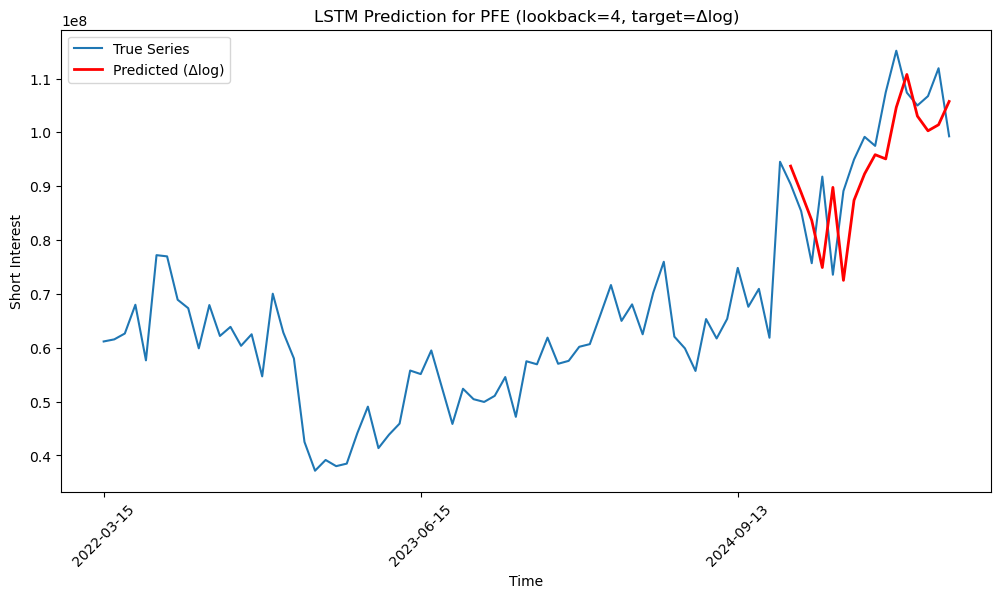

In [3]:
# ---------- model (predicts log-return) ----------
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # output: Δlog
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)
    
class EnhancedLSTMTimeSeries(nn.Module):
    def __init__(self, input_size=18, hidden_size=64, num_layers=3, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the last time step output
        last_output = lstm_out[:, -1, :]
        
        # Feed through fully connected layers
        out = self.dropout(last_output)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

model = EnhancedLSTMTimeSeries(input_size=2, hidden_size=32, num_layers=2, output_size=1)
criterion = nn.SmoothL1Loss()         # Huber; more robust than MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---------- training ----------
epochs = 60
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)               # predicts Δlog
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

# ---------- evaluation: predict log-returns and reconstruct levels ----------
model.eval()
pred_logret = []
with torch.no_grad():
    for xb, _ in test_loader:
        pred_logret.append(model(xb).numpy())
pred_logret = np.concatenate(pred_logret, axis=0).ravel()     # (N_test,)

# reconstruct levels: ŷ_t = exp(prev_log_t + r̂_t)
y_pred_levels = np.exp(prev_log_test + pred_logret)

# true levels aligned with the targets (these are y_t for the test windows)
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---------- plot ----------
plt.figure(figsize=(12, 6))
plt.plot(range(len(SI_series)), SI_series.reshape(-1), label='True Series', linewidth=1.5)
start = split + lookback_window
end = start + len(y_pred_levels)
plt.plot(range(start, end), y_pred_levels, label='Predicted (Δlog)', color='red', linewidth=2)
plt.title(f'LSTM Prediction for {stock} (lookback={lookback_window}, target=Δlog)')
# Set x-ticks to si_dates, display every 30 days
xtick_idx = np.arange(0, len(si_dates), 30)
plt.xticks(xtick_idx, si_dates[xtick_idx].strftime('%Y-%m-%d'), rotation=45)
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.show()

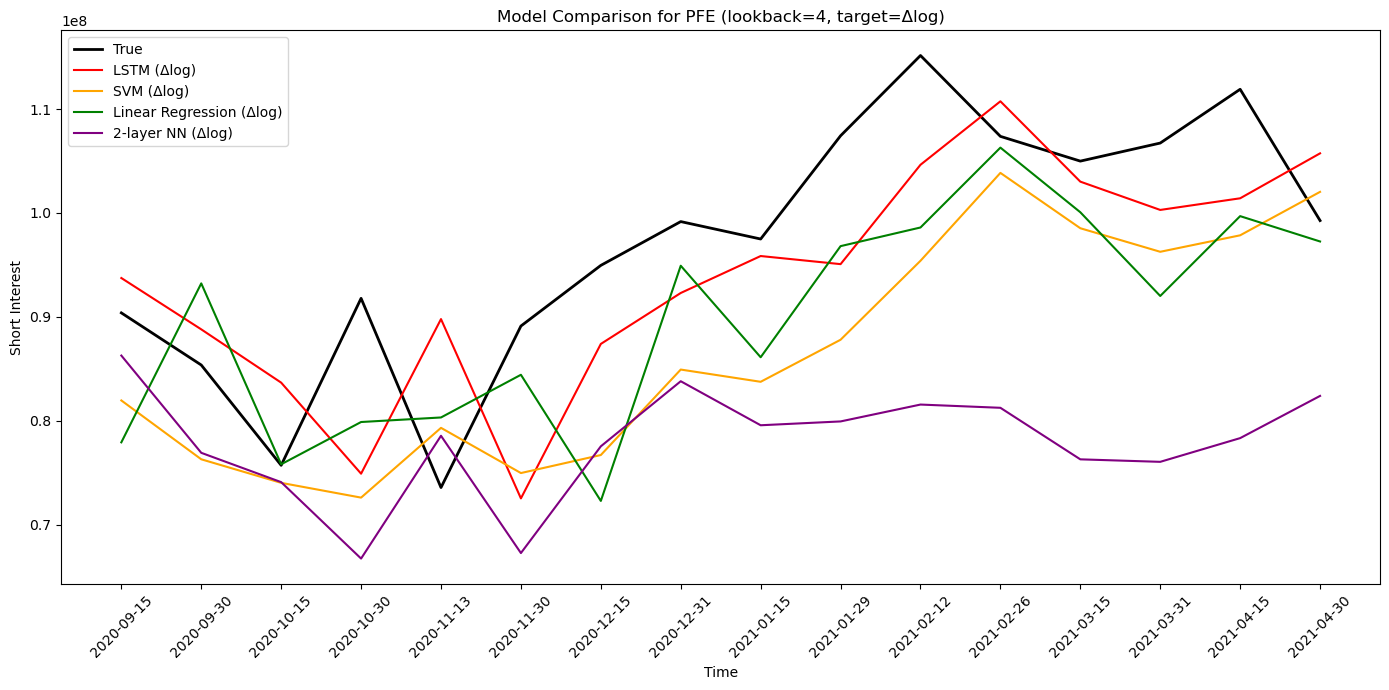

            Model     MAPE         RMSE
             LSTM 0.088417 9.646724e+06
              SVM 0.115311 1.281604e+07
Linear Regression 0.091922 1.081253e+07
       2-layer NN 0.193523 2.212084e+07


In [4]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Assumes these already exist from your Δlog pipeline:
# X_train, X_test                # scaled inputs (L,1) windows
# y_train, y_test                # targets = Δlog(y) with shape (N,1)
# prev_log_test                  # np.array of log(y_{t-1}) for each X_test row, shape (N,)
# y_pred_levels (from LSTM)      # optional, if you already computed it
# series                         # original level series (T,1)
# split, lookback_window         # same as before
# dates                          # index for plotting (use the SI series index)
# -------------------------------------------------

# flatten inputs for sklearn
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

# ---- SVM predicts Δlog ----
svm = SVR()
svm.fit(X_train_flat, y_train.ravel())
svm_logret  = svm.predict(X_test_flat)                 # r̂_t
svm_levels  = np.exp(prev_log_test + svm_logret)       # ŷ_t

# ---- Linear Regression predicts Δlog ----
lr = LinearRegression()
lr.fit(X_train_flat, y_train.ravel())
lr_logret   = lr.predict(X_test_flat)
lr_levels   = np.exp(prev_log_test + lr_logret)

# ---- 2-layer MLP predicts Δlog ----
import torch.nn as nn

# Define a simple 2-layer NN for regression
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_torch = SimpleMLP(X_train_flat.shape[1])
optimizer_mlp = torch.optim.Adam(mlp_torch.parameters(), lr=1e-3)
criterion_mlp = nn.SmoothL1Loss()

X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_flat, dtype=torch.float32)

# Train the model
epochs_mlp = 100
for epoch in range(epochs_mlp):
    mlp_torch.train()
    optimizer_mlp.zero_grad()
    output = mlp_torch(X_train_tensor)
    loss = criterion_mlp(output, y_train_tensor)
    loss.backward()
    optimizer_mlp.step()

# Predict
mlp_logret = mlp_torch(X_test_tensor).detach().numpy().ravel()
mlp_levels = np.exp(prev_log_test + mlp_logret)

# ---- LSTM levels (from your earlier step) ----
lstm_levels = y_pred_levels  # keep your variable name

# ---- True levels aligned to the test targets ----
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---- Plot test period only ----
dates = ticker_timeseries[stock]['SI'].dropna().index  # for x-ticks
plt.figure(figsize=(14,7))
test_idx = range(split + lookback_window, split + lookback_window + len(y_true_levels))
plt.plot(test_idx, y_true_levels, label='True', color='black', linewidth=2)
plt.plot(test_idx, lstm_levels, label='LSTM (Δlog)', color='red')
plt.plot(test_idx, svm_levels,  label='SVM (Δlog)', color='orange')
plt.plot(test_idx, lr_levels,   label='Linear Regression (Δlog)', color='green')
plt.plot(test_idx, mlp_levels,  label='2-layer NN (Δlog)', color='purple')
plt.xticks(
    ticks=test_idx,
    labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)].strftime('%Y-%m-%d'),
    rotation=45
)
plt.title(f'Model Comparison for {stock} (lookback={lookback_window}, target=Δlog)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Metrics on ORIGINAL LEVELS ----
def get_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, rmse

results = []
for name, pred in [ 
    ("LSTM", lstm_levels),
    ("SVM", svm_levels),
    ("Linear Regression", lr_levels),
    ("2-layer NN", mlp_levels),
]:
    mape, rmse = get_metrics(y_true_levels, pred)
    results.append({"Model": name, "MAPE": mape, "RMSE": rmse})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


# with rolling average of news sentiment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
from collections import defaultdict

# ---------- params ----------
lookback_window = 4
stock = 'PFE'
eps = 1e-8  # to avoid log(0)
api_key = '7JIMRNYIWH5MTWOF'  # Replace with your actual API key
lag_days = 7

# ---------- News Sentiment Data Collection ----------
def get_news_sentiment(ticker, api_key, time_from=None, time_to=None, limit=1000):
    """
    Fetch news sentiment data from Alpha Vantage API in batches, rolling time_to as current_to.
    Returns all news items between time_from and time_to.
    """
    all_news = []
    current_to = time_to

    while True:
        url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={ticker}&apikey={api_key}&limit={limit}'
        if time_from:
            url += f'&time_from={time_from}'
        if current_to:
            url += f'&time_to={current_to}'

        try:
            r = requests.get(url)
            data = r.json()

            if 'feed' not in data or not data['feed']:
                print(f"No more news data found or API limit reached. Keys in response: {list(data.keys())}")
                break

            news_batch = []
            for item in data['feed']:
                ticker_sentiment = None
                for ticker_data in item.get('ticker_sentiment', []):
                    if ticker_data['ticker'] == ticker:
                        ticker_sentiment = ticker_data
                        break

                if ticker_sentiment:
                    news_item = {
                        'date': item['time_published'][:8],  # YYYYMMDD format
                        'sentiment_score': float(ticker_sentiment['ticker_sentiment_score']),
                        'relevance_score': float(ticker_sentiment['relevance_score'])
                    }
                    news_batch.append(news_item)

            if not news_batch:
                break

            all_news.extend(news_batch)

            # Find the oldest news item's time_published in this batch
            oldest_time = min(item['date'] for item in news_batch)
            # Move current_to to just before the oldest_time to avoid duplicates
            current_to = oldest_time + 'T0000'

            # If we've reached the start date, stop
            if current_to <= time_from:
                break

            # To avoid hitting API rate limits
            time.sleep(1)

        except Exception as e:
            print(f"Error fetching news data: {e}")
            break

    return all_news

def create_sentiment_features(si_dates, news_data, lag_days=7):
    """
    Create sentiment features for each SI date with 7-day lag structure
    Features: [7day_avg_sentiment, 7day_news_count, day1_avg, day1_count, ..., day7_avg, day7_count]
    """
    # Convert news data to DataFrame for easier manipulation
    if not news_data:
        print("No news data available, creating zero features")
        return np.zeros((len(si_dates), 16))  # 2 + 7*2 = 16 features
    
    news_df = pd.DataFrame(news_data)
    news_df['date'] = pd.to_datetime(news_df['date'], format='%Y%m%d')
    
    # Group news by date and calculate daily averages
    daily_sentiment = news_df.groupby('date').agg({
        'sentiment_score': 'mean',
        'relevance_score': 'count'  # count as number of news
    }).rename(columns={'relevance_score': 'news_count'})
    
    sentiment_features = []
    
    for si_date in si_dates:
        si_datetime = pd.to_datetime(si_date)
        
        # Define the 7-day window (lag_days before the SI date)
        window_end = si_datetime - timedelta(days=1)  # Day before SI date
        window_start = window_end - timedelta(days=lag_days-1)  # 7 days back
        
        # Get sentiment data for the window
        window_data = daily_sentiment[
            (daily_sentiment.index >= window_start) & 
            (daily_sentiment.index <= window_end)
        ]
        
        # Feature 1-2: 7-day average sentiment and news count
        if len(window_data) > 0:
            avg_sentiment_7d = window_data['sentiment_score'].mean()
            total_news_7d = window_data['news_count'].sum()
        else:
            avg_sentiment_7d = 0.0
            total_news_7d = 0
        
        features = [avg_sentiment_7d, total_news_7d]
        
        # Features 3-16: Daily averages for each of the 7 days
        for day_offset in range(lag_days):
            target_date = window_end - timedelta(days=day_offset)
            
            if target_date in daily_sentiment.index:
                daily_avg = daily_sentiment.loc[target_date, 'sentiment_score']
                daily_count = daily_sentiment.loc[target_date, 'news_count']
            else:
                daily_avg = 0.0
                daily_count = 0
            
            features.extend([daily_avg, daily_count])
        
        sentiment_features.append(features)
    
    return np.array(sentiment_features)

def my_create_sentiment_features(si_dates, news_data, lag_days=7):
    """
    Create sentiment features for each SI date with 7-day lag structure
    Features: [7day_avg_sentiment, 7day_news_count, day1_avg, day1_count, ..., day7_avg, day7_count]
    """
    # Convert news data to DataFrame for easier manipulation
    if not news_data:
        print("No news data available, creating zero features")
        return np.zeros((len(si_dates), 16))  # 2 + 7*2 = 16 features
    
    news_df = pd.DataFrame(news_data)
    news_df['date'] = pd.to_datetime(news_df['date'], format='%Y%m%d')
    
    # Group news by date and calculate daily averages
    daily_sentiment = news_df.groupby('date').agg({
        'sentiment_score': 'mean',
        'relevance_score': 'count'  # count as number of news
    }).rename(columns={'relevance_score': 'news_count'})
    
    sentiment_features = []
    
    for i, si_date in enumerate(si_dates):
        if i == 0:
            prev_date = pd.to_datetime('20220301')  # or some other start date
        else:
            prev_date = pd.to_datetime(si_dates[i-1])
        si_datetime = pd.to_datetime(si_date)
        
        # Define the 7-day window (lag_days before the SI date)
        window_end = si_datetime - timedelta(days=1)  # Day before SI date
        window_start = prev_date + timedelta(days=lag_days)  # 7 days back
        
        # Get sentiment data for the window
        prev_sentiment_data = daily_sentiment[(daily_sentiment.index >= prev_date) & (daily_sentiment.index < window_start)]
        
        window_data = daily_sentiment[
            (daily_sentiment.index >= window_start) & 
            (daily_sentiment.index <= window_end)
        ]
        
        # Feature 1-2: 7-day average sentiment and news count
        if len(window_data) > 0:
            avg_sentiment_7d = window_data['sentiment_score'].mean()
            total_news_7d = window_data['news_count'].sum()
        else:
            avg_sentiment_7d = 0.0
            total_news_7d = 0
        
        features = [avg_sentiment_7d, total_news_7d]
        
        # Features 3-16: Daily averages for each of the 7 days
        for day_offset in range(lag_days):
            target_date = window_end - timedelta(days=day_offset)
            
            if target_date in daily_sentiment.index:
                daily_avg = daily_sentiment.loc[target_date, 'sentiment_score']
                daily_count = daily_sentiment.loc[target_date, 'news_count']
            else:
                daily_avg = 0.0
                daily_count = 0
            
            features.extend([daily_avg, daily_count])
        
        sentiment_features.append(features)
    
    return np.array(sentiment_features)


In [122]:
# ---------- data ----------
# raw levels (T, 2)
si_dates = ticker_timeseries[stock]['SI'].dropna().index

SI_series = ticker_timeseries[stock]['SI'][si_dates>pd.to_datetime('20220301')].dropna().values.astype(np.float64).reshape(-1, 1)
vol_series = ticker_timeseries[stock]['Volume'][si_dates>pd.to_datetime('20220301')].dropna().values.astype(np.float64).reshape(-1, 1)
si_dates = si_dates[si_dates>pd.to_datetime('20220301')]

# Fetch news sentiment data
print("Fetching news sentiment data...")
news_data = get_news_sentiment(stock, api_key, time_from='20220301T0001', time_to='20250714T2359', limit=1000)
print(f"Retrieved {len(news_data)} news items")

# Create sentiment features
print("Creating sentiment features...")
sentiment_features = create_sentiment_features(si_dates, news_data, lag_days)
print(f"Sentiment features shape: {sentiment_features.shape}")

Fetching news sentiment data...
Retrieved 12625 news items
Creating sentiment features...
Sentiment features shape: (81, 16)


Combined features shape: (81, 4)
Model input size: 18
Training data shape: (61, 4, 4)
Epoch 1/80, Train Loss: 0.017689
Epoch 11/80, Train Loss: 0.008896
Early stopping at epoch 19

Model Performance:
MAE: 8110694.4743
RMSE: 9483593.3867
MAPE: 8.86%


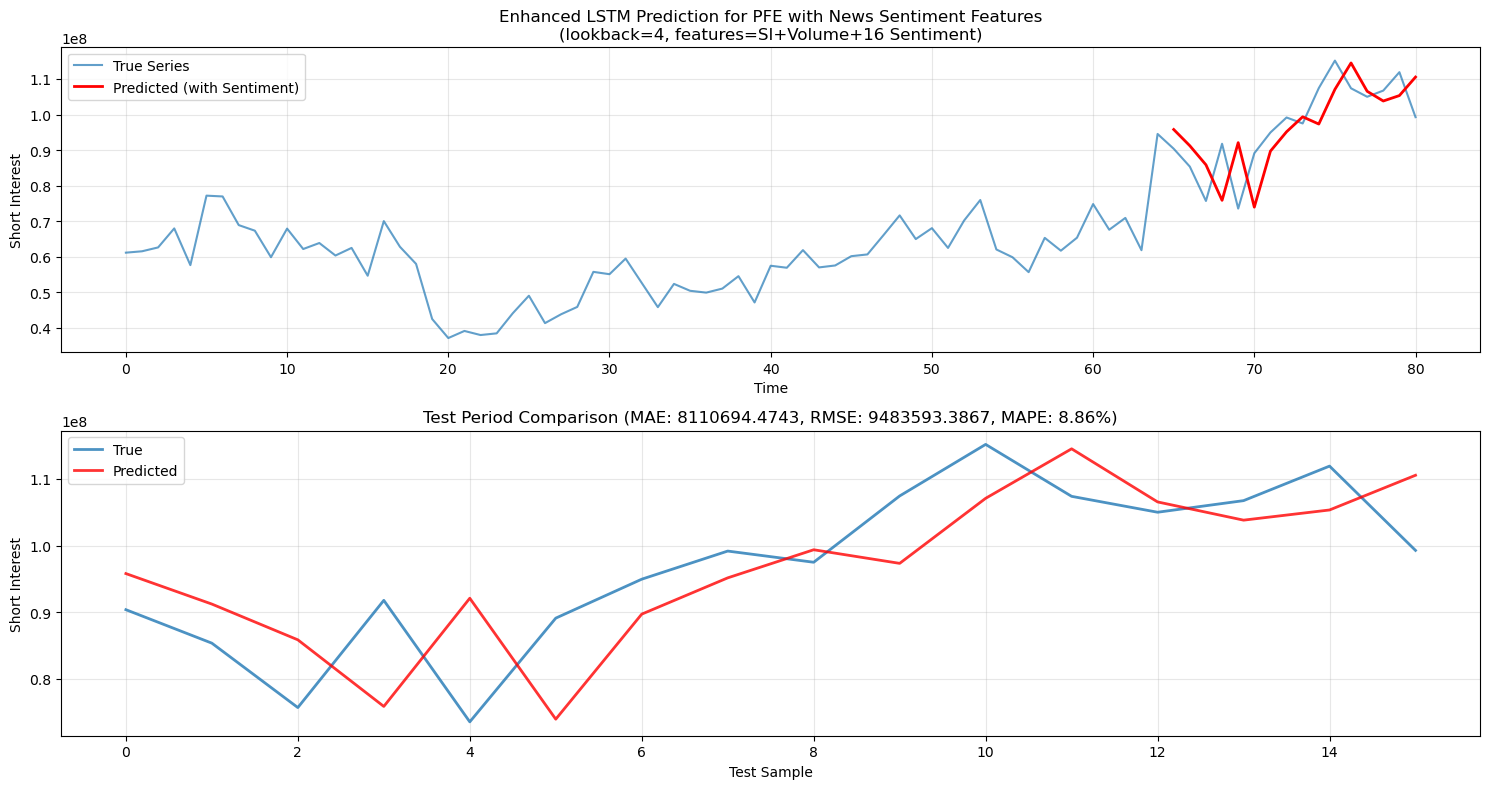


Sentiment Feature Statistics:
7-day avg sentiment range: [-0.0717, 0.1602]
7-day news count range: [12, 296]
Non-zero sentiment days: 539 out of 567


In [123]:
# Combine all features: [SI, Volume, 16 sentiment features]
level_series = np.concatenate([SI_series, vol_series, sentiment_features[:, :2]], axis=1)  # (T, 4)
print(f"Combined features shape: {level_series.shape}")

# log of SI levels (T,) for the target
series_safe = np.where(SI_series <= 0, eps, SI_series).reshape(-1)
y_log = np.log(series_safe)

# build supervised windows with log-return target
def make_windows_level_to_logret(level_series, y_log, lookback):
    X_list, y_logret_list, prev_log_list = [], [], []
    for t in range(lookback, len(level_series)):
        X_list.append(level_series[t - lookback:t, :])                  # (L, 4)
        y_logret_list.append([y_log[t] - y_log[t - 1]])                 # (1,)
        prev_log_list.append(y_log[t - 1])   
    X = np.asarray(X_list)                          # (N, L, 4)
    y_logret = np.asarray(y_logret_list)            # (N, 1)
    prev_log = np.asarray(prev_log_list)            # (N,)
    return X, y_logret, prev_log

X_raw, y_logret, prev_log_all = make_windows_level_to_logret(level_series, y_log, lookback_window)

# ---------- split ----------
N = X_raw.shape[0]
split = int(0.8 * N)
X_train_raw, X_test_raw = X_raw[:split], X_raw[split:]
y_train, y_test = y_logret[:split], y_logret[split:]
prev_log_train, prev_log_test = prev_log_all[:split], prev_log_all[split:]

# ---------- scale inputs ONLY (per-feature, fit on train) ----------
# Reshape for scaling: (N*L, features) -> scale -> reshape back
scaler = StandardScaler()
X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[-1])
scaler.fit(X_train_reshaped)

X_train = scaler.transform(X_train_reshaped).reshape(X_train_raw.shape)
X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[-1])
X_test = scaler.transform(X_test_reshaped).reshape(X_test_raw.shape)

# ---------- tensors / loaders ----------
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

batch_size = 8
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)

# ---------- enhanced model (predicts log-return) ----------
class EnhancedLSTMTimeSeries(nn.Module):
    def __init__(self, input_size=18, hidden_size=64, num_layers=3, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the last time step output
        last_output = lstm_out[:, -1, :]
        
        # Feed through fully connected layers
        out = self.dropout(last_output)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Updated model with more capacity for additional features
model = EnhancedLSTMTimeSeries(input_size=4, hidden_size=64, num_layers=3, output_size=1)
# model = LSTMTimeSeries(input_size=4, hidden_size=64, num_layers=3, output_size=1)
criterion = nn.SmoothL1Loss()         # Huber; more robust than MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print(f"Model input size: {18}")
print(f"Training data shape: {X_train.shape}")

# ---------- training ----------
epochs = 80
best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)               # predicts Δlog
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# ---------- evaluation: predict log-returns and reconstruct levels ----------
model.eval()
pred_logret = []
with torch.no_grad():
    for xb, _ in test_loader:
        pred_logret.append(model(xb).numpy())
pred_logret = np.concatenate(pred_logret, axis=0).ravel()     # (N_test,)

# reconstruct levels: ŷ_t = exp(prev_log_t + r̂_t)
y_pred_levels = np.exp(prev_log_test + pred_logret)

# true levels aligned with the targets (these are y_t for the test windows)
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# Calculate metrics
mae = np.mean(np.abs(y_pred_levels - y_true_levels))
rmse = np.sqrt(np.mean((y_pred_levels - y_true_levels)**2))
mape = np.mean(np.abs((y_true_levels - y_pred_levels) / y_true_levels)) * 100

print(f"\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------- plot ----------
plt.figure(figsize=(15, 8))

# Plot full series
plt.subplot(2, 1, 1)
plt.plot(range(len(SI_series)), SI_series.reshape(-1), label='True Series', linewidth=1.5, alpha=0.7)
start = split + lookback_window
end = start + len(y_pred_levels)
plt.plot(range(start, end), y_pred_levels, label='Predicted (with Sentiment)', color='red', linewidth=2)
plt.title(f'Enhanced LSTM Prediction for {stock} with News Sentiment Features\n(lookback={lookback_window}, features=SI+Volume+16 Sentiment)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot test period only
plt.subplot(2, 1, 2)
test_range = range(len(y_true_levels))
plt.plot(test_range, y_true_levels, label='True', linewidth=2, alpha=0.8)
plt.plot(test_range, y_pred_levels, label='Predicted', color='red', linewidth=2, alpha=0.8)
plt.title(f'Test Period Comparison (MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%)')
plt.xlabel('Test Sample')
plt.ylabel('Short Interest')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------- Feature importance analysis ----------
print(f"\nSentiment Feature Statistics:")
print(f"7-day avg sentiment range: [{sentiment_features[:, 0].min():.4f}, {sentiment_features[:, 0].max():.4f}]")
print(f"7-day news count range: [{sentiment_features[:, 1].min():.0f}, {sentiment_features[:, 1].max():.0f}]")
print(f"Non-zero sentiment days: {np.sum(sentiment_features[:, 2::2] != 0)} out of {sentiment_features[:, 2::2].size}")

Flattened training data shape: (61, 16)
Flattened test data shape: (16, 16)
Feature dimension per sample: 16 (lookback=4 × features=18)
Training SVM...
Training Linear Regression...
Training 2-layer MLP...
MLP Epoch 1/100, Loss: 0.036655
MLP Epoch 21/100, Loss: 0.010648
MLP Epoch 41/100, Loss: 0.007265
MLP Epoch 61/100, Loss: 0.005579
MLP Epoch 81/100, Loss: 0.004450


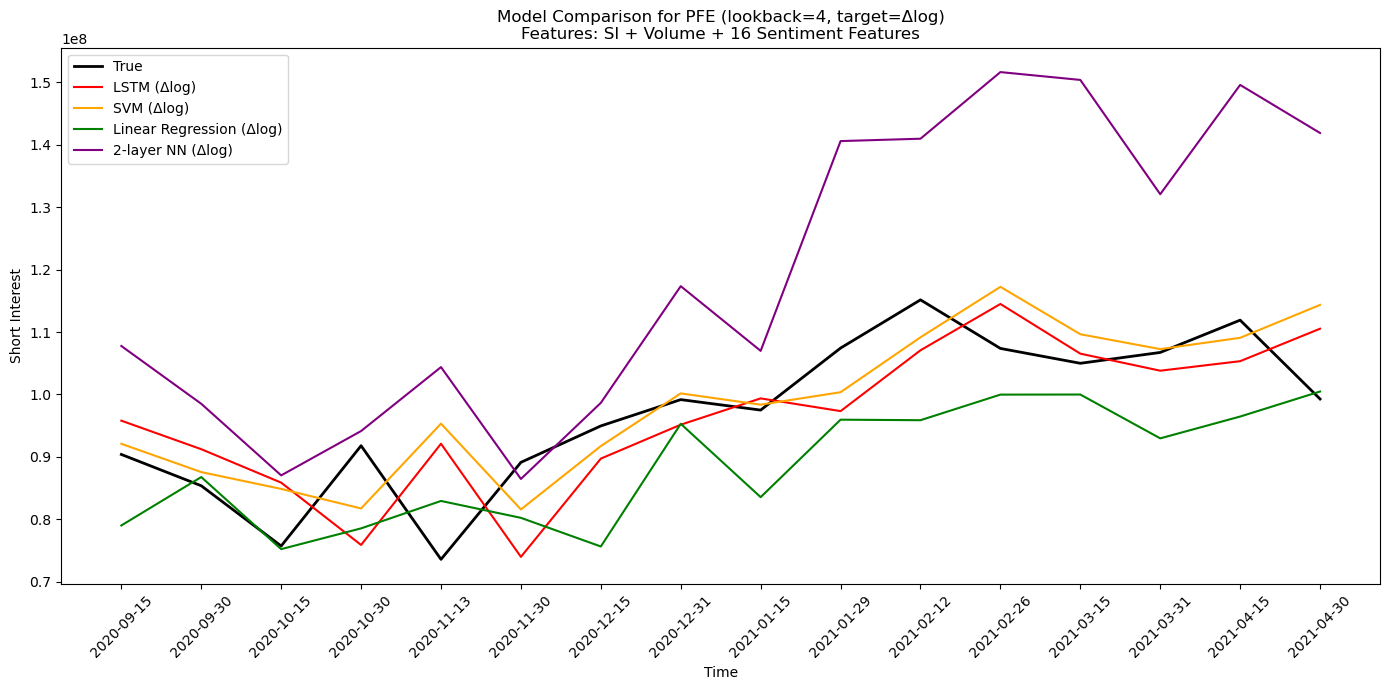


MODEL PERFORMANCE COMPARISON
            Model          MAE    MAPE         RMSE
              SVM 6.472504e+06  7.1556 8.573320e+06
             LSTM 8.110694e+06  8.8609 9.483593e+06
Linear Regression 9.721149e+06  9.8511 1.137625e+07
       2-layer NN 2.271559e+07 22.9491 2.701122e+07

Best performing model: SVM (MAPE: 7.16%)
LSTM rank: 1 out of 4
SVM vs Linear Regression: 27.4% improvement
LSTM vs Linear Regression: 10.1% improvement
2-layer NN vs Linear Regression: -133.0% worse


In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# -------------------------------------------------
# Assumes these already exist from your Δlog pipeline:
# X_train, X_test                # scaled inputs (N,L,18) windows
# y_train, y_test                # targets = Δlog(y) with shape (N,1)
# prev_log_test                  # np.array of log(y_{t-1}) for each X_test row, shape (N,)
# y_pred_levels (from LSTM)      # optional, if you already computed it
# SI_series                      # original level series (T,1)
# split, lookback_window         # same as before
# dates                          # index for plotting (use the SI series index)
# -------------------------------------------------

# Flatten inputs for sklearn (from 3D to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (N, lookback * 18)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)    # (N_test, lookback * 18)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")
print(f"Feature dimension per sample: {X_train_flat.shape[1]} (lookback={lookback_window} × features=18)")

# ---- SVM predicts Δlog ----
print("Training SVM...")
svm = SVR()
svm.fit(X_train_flat, y_train.ravel())
svm_logret  = svm.predict(X_test_flat)                 # r̂_t
svm_levels  = np.exp(prev_log_test + svm_logret)       # ŷ_t

# ---- Linear Regression predicts Δlog ----
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_flat, y_train.ravel())
lr_logret   = lr.predict(X_test_flat)
lr_levels   = np.exp(prev_log_test + lr_logret)

# ---- 2-layer MLP predicts Δlog ----
print("Training 2-layer MLP...")

# Define a simple 2-layer NN for regression
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_torch = SimpleMLP(X_train_flat.shape[1])
optimizer_mlp = torch.optim.Adam(mlp_torch.parameters(), lr=1e-3)
criterion_mlp = nn.SmoothL1Loss()

X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_flat, dtype=torch.float32)

# Train the model
epochs_mlp = 100
for epoch in range(epochs_mlp):
    mlp_torch.train()
    optimizer_mlp.zero_grad()
    output = mlp_torch(X_train_tensor)
    loss = criterion_mlp(output, y_train_tensor)
    loss.backward()
    optimizer_mlp.step()
    
    if epoch % 20 == 0:
        print(f"MLP Epoch {epoch+1}/{epochs_mlp}, Loss: {loss.item():.6f}")

# Predict
mlp_torch.eval()
with torch.no_grad():
    mlp_logret = mlp_torch(X_test_tensor).detach().numpy().ravel()
mlp_levels = np.exp(prev_log_test + mlp_logret)

# ---- LSTM levels (from your earlier step) ----
lstm_levels = y_pred_levels  # keep your variable name

# ---- True levels aligned to the test targets ----
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---- Plot test period only ----
dates = ticker_timeseries[stock]['SI'].dropna().index  # for x-ticks
plt.figure(figsize=(14,7))
test_idx = range(split + lookback_window, split + lookback_window + len(y_true_levels))
plt.plot(test_idx, y_true_levels, label='True', color='black', linewidth=2)
plt.plot(test_idx, lstm_levels, label='LSTM (Δlog)', color='red')
plt.plot(test_idx, svm_levels,  label='SVM (Δlog)', color='orange')
plt.plot(test_idx, lr_levels,   label='Linear Regression (Δlog)', color='green')
plt.plot(test_idx, mlp_levels,  label='2-layer NN (Δlog)', color='purple')

# Format x-axis with actual dates
if len(test_idx) <= 20:  # Only show date labels if not too many points
    plt.xticks(
        ticks=test_idx,
        labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)].strftime('%Y-%m-%d'),
        rotation=45
    )
else:
    # Show fewer date labels for better readability
    step = len(test_idx) // 10
    selected_idx = test_idx[::step]
    plt.xticks(
        ticks=selected_idx,
        labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)][::step].strftime('%Y-%m-%d'),
        rotation=45
    )

plt.title(f'Model Comparison for {stock} (lookback={lookback_window}, target=Δlog)\nFeatures: SI + Volume + 16 Sentiment Features')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Metrics on ORIGINAL LEVELS ----
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

results = []
for name, pred in [ 
    ("LSTM", lstm_levels),
    ("SVM", svm_levels),
    ("Linear Regression", lr_levels),
    ("2-layer NN", mlp_levels),
]:
    mae, mape, rmse = get_metrics(y_true_levels, pred)
    results.append({"Model": name, "MAE": mae, "MAPE": mape*100, "RMSE": rmse})

results_df = pd.DataFrame(results)
# Sort by MAPE (lower is better)
results_df = results_df.sort_values('MAPE')

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(results_df.round(4).to_string(index=False))


# With stock price

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
from collections import defaultdict

# ---------- params ----------
lookback_window = 4
stock = 'PFE'
eps = 1e-8  # to avoid log(0)
api_key = '7JIMRNYIWH5MTWOF'  # Replace with your actual API key
lag_days = 7

# ---------- Stock Price Data Collection ----------
def get_stock_price_data(symbol, api_key, outputsize='full'):
    """
    Fetch daily OHLC stock price data from Alpha Vantage API
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize={outputsize}'
    
    try:
        r = requests.get(url)
        data = r.json()
        
        if 'Time Series (Daily)' not in data:
            print(f"No price data found or API limit reached. Keys in response: {list(data.keys())}")
            return pd.DataFrame()
        
        # Convert to DataFrame
        price_data = data['Time Series (Daily)']
        df = pd.DataFrame.from_dict(price_data, orient='index')
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Convert to numeric and sort by date
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])
        
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        return df[['Open', 'High', 'Low', 'Close']]  # Only OHLC
        
    except Exception as e:
        print(f"Error fetching price data: {e}")
        return pd.DataFrame()

def create_price_features(si_dates, price_data, gap_days=15):
    """
    Create daily OHLC price features for each SI date with 7-day lag structure
    Features: [day1_open, day1_high, day1_low, day1_close, ..., day7_open, day7_high, day7_low, day7_close]
    Total: 4 * 7 = 28 features
    """
    if price_data.empty:
        print("No price data available, creating zero features")
        return np.zeros((len(si_dates), 28))  # 4*7 = 28 features
    
    price_features = []
    
    for si_date in si_dates:
        si_datetime = pd.to_datetime(si_date)

        # Define the 14-day window (gap_days before the SI date)
        window_end = si_datetime - timedelta(days=1)  # Day before SI date
        
        features = []

        # Get price data for each of the 15 days
        for day_offset in range(gap_days):
            target_date = window_end - timedelta(days=day_offset)
            
            # Find the closest trading day (in case of weekends/holidays)
            closest_date = None
            min_diff = timedelta(days=10)  # Max search window
            
            for price_date in price_data.index:
                diff = abs(price_date.date() - target_date.date())
                if diff < min_diff:
                    min_diff = diff
                    closest_date = price_date
            
            if closest_date is not None and min_diff <= timedelta(days=3):  # Within 3 days
                day_data = price_data.loc[closest_date]
                features.extend([
                    day_data['Open'],
                    day_data['High'], 
                    day_data['Low'],
                    day_data['Close']
                ])
            else:
                # No data available, use NaNs
                features.extend([np.nan, np.nan, np.nan, np.nan])
        
        price_features.append(features)
    price_features = np.array(price_features)
    # Handle NaNs by imputing with column means
    col_means = np.nanmean(price_features, axis=0)
    price_features = np.where(np.isnan(price_features), col_means, price_features)

    return price_features

In [4]:
# ---------- data ----------
# raw levels (T, 2)
gap_days = 15
si_dates = ticker_timeseries[stock]['SI'].dropna().index

SI_series = ticker_timeseries[stock]['SI'].dropna().values.astype(np.float64).reshape(-1, 1)
vol_series = ticker_timeseries[stock]['Volume'].dropna().values.astype(np.float64).reshape(-1, 1)

# Fetch stock price data
print("Fetching stock price data...")
price_data = get_stock_price_data(stock, api_key)
print(f"Retrieved price data for {len(price_data)} trading days")
if not price_data.empty:
    print(f"Price data date range: {price_data.index.min()} to {price_data.index.max()}")

# Create price features
print("Creating price features...")
price_features = create_price_features(si_dates, price_data, gap_days)
print(f"Price features shape: {price_features.shape}")

# Combine all features: [SI, Volume, 60 price features]
level_series = np.concatenate([SI_series, vol_series, price_features], axis=1)  # (T, 62)
print(f"Combined features shape: {level_series.shape}")


Fetching stock price data...
Retrieved price data for 6505 trading days
Price data date range: 1999-11-01 00:00:00 to 2025-09-11 00:00:00
Creating price features...
Price features shape: (182, 60)
Combined features shape: (182, 62)


Model input size: 62
Training data shape: (142, 4, 62)
Epoch 1/80, Train Loss: 0.017146
Epoch 11/80, Train Loss: 0.014333
Epoch 21/80, Train Loss: 0.013828
Epoch 31/80, Train Loss: 0.013315
Epoch 41/80, Train Loss: 0.012325
Epoch 51/80, Train Loss: 0.010943
Epoch 61/80, Train Loss: 0.007697
Early stopping at epoch 62

Model Performance:
MAE: 7586331.9715
RMSE: 9773015.1806
MAPE: 9.40%


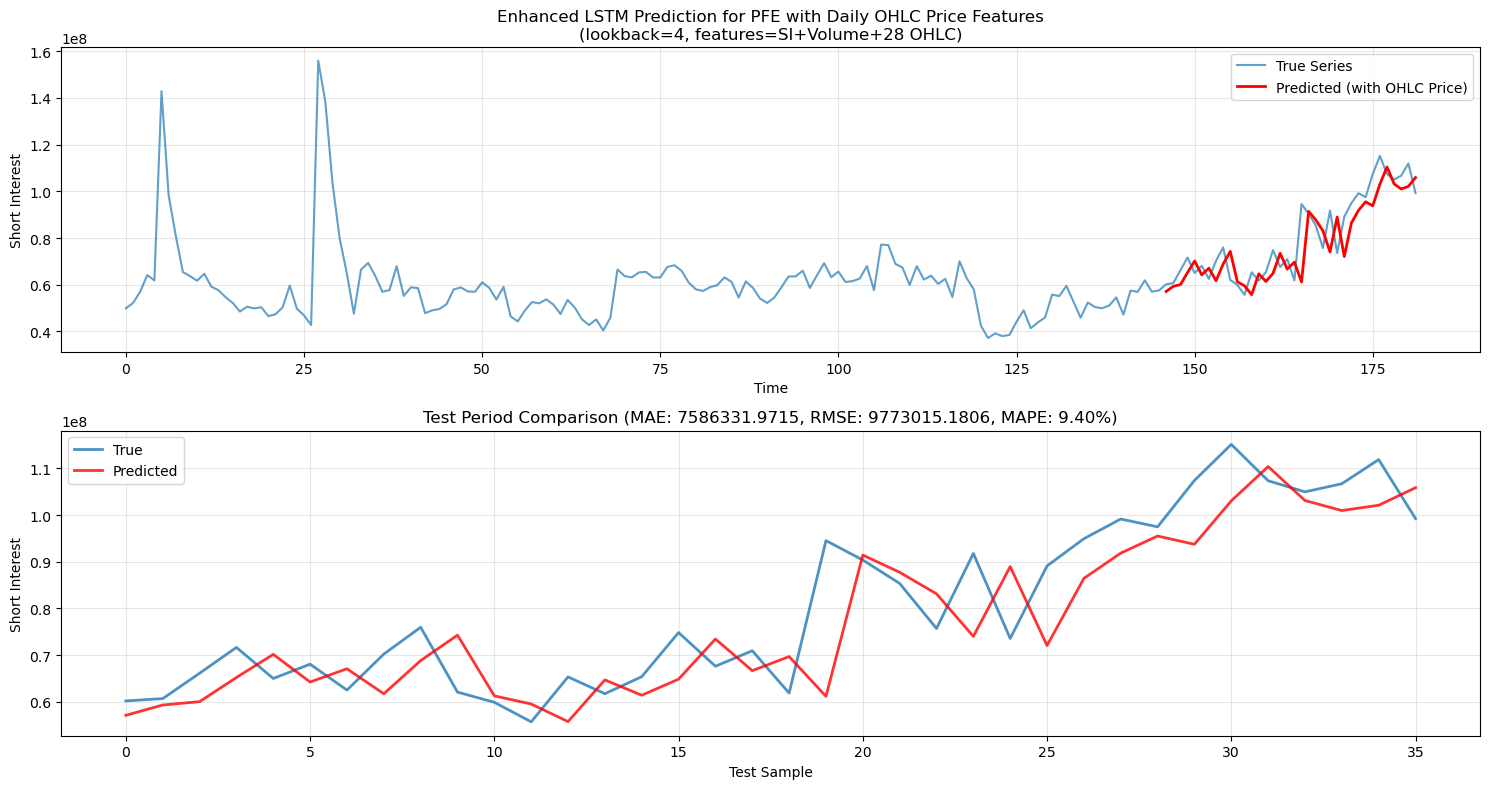

In [5]:

# log of SI levels (T,) for the target
series_safe = np.where(SI_series <= 0, eps, SI_series).reshape(-1)
y_log = np.log(series_safe)

# build supervised windows with log-return target
def make_windows_level_to_logret(level_series, y_log, lookback):
    X_list, y_logret_list, prev_log_list = [], [], []
    for t in range(lookback, len(level_series)):
        X_list.append(level_series[t - lookback:t, :])                  # (L, 62)
        y_logret_list.append([y_log[t] - y_log[t - 1]])                 # (1,)
        prev_log_list.append(y_log[t - 1])   
    X = np.asarray(X_list)                          # (N, L, 62)
    y_logret = np.asarray(y_logret_list)            # (N, 1)
    prev_log = np.asarray(prev_log_list)            # (N,)
    return X, y_logret, prev_log

X_raw, y_logret, prev_log_all = make_windows_level_to_logret(level_series, y_log, lookback_window)

# ---------- split ----------
N = X_raw.shape[0]
split = int(0.8 * N)
X_train_raw, X_test_raw = X_raw[:split], X_raw[split:]
y_train, y_test = y_logret[:split], y_logret[split:]
prev_log_train, prev_log_test = prev_log_all[:split], prev_log_all[split:]

# ---------- scale inputs ONLY (per-feature, fit on train) ----------
# Reshape for scaling: (N*L, features) -> scale -> reshape back
scaler = StandardScaler()
X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[-1])
scaler.fit(X_train_reshaped)

X_train = scaler.transform(X_train_reshaped).reshape(X_train_raw.shape)
X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[-1])
X_test = scaler.transform(X_test_reshaped).reshape(X_test_raw.shape)

# ---------- tensors / loaders ----------
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

batch_size = 8
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)

# ---------- enhanced model (predicts log-return) ----------
class EnhancedLSTMTimeSeries(nn.Module):
    def __init__(self, input_size=30, hidden_size=64, num_layers=3, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the last time step output
        last_output = lstm_out[:, -1, :]
        
        # Feed through fully connected layers
        out = self.dropout(last_output)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Updated model with more capacity for additional features
model = EnhancedLSTMTimeSeries(input_size=62, hidden_size=64, num_layers=3, output_size=1)
criterion = nn.SmoothL1Loss()         # Huber; more robust than MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print(f"Model input size: {62}")
print(f"Training data shape: {X_train.shape}")

# ---------- training ----------
epochs = 80
best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)               # predicts Δlog
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# ---------- evaluation: predict log-returns and reconstruct levels ----------
model.eval()
pred_logret = []
with torch.no_grad():
    for xb, _ in test_loader:
        pred_logret.append(model(xb).numpy())
pred_logret = np.concatenate(pred_logret, axis=0).ravel()     # (N_test,)

# reconstruct levels: ŷ_t = exp(prev_log_t + r̂_t)
y_pred_levels = np.exp(prev_log_test + pred_logret)

# true levels aligned with the targets (these are y_t for the test windows)
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# Calculate metrics
mae = np.mean(np.abs(y_pred_levels - y_true_levels))
rmse = np.sqrt(np.mean((y_pred_levels - y_true_levels)**2))
mape = np.mean(np.abs((y_true_levels - y_pred_levels) / y_true_levels)) * 100

print(f"\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------- plot ----------
plt.figure(figsize=(15, 8))

# Plot full series
plt.subplot(2, 1, 1)
plt.plot(range(len(SI_series)), SI_series.reshape(-1), label='True Series', linewidth=1.5, alpha=0.7)
start = split + lookback_window
end = start + len(y_pred_levels)
plt.plot(range(start, end), y_pred_levels, label='Predicted (with OHLC Price)', color='red', linewidth=2)
plt.title(f'Enhanced LSTM Prediction for {stock} with Daily OHLC Price Features\n(lookback={lookback_window}, features=SI+Volume+28 OHLC)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot test period only
plt.subplot(2, 1, 2)
test_range = range(len(y_true_levels))
plt.plot(test_range, y_true_levels, label='True', linewidth=2, alpha=0.8)
plt.plot(test_range, y_pred_levels, label='Predicted', color='red', linewidth=2, alpha=0.8)
plt.title(f'Test Period Comparison (MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%)')
plt.xlabel('Test Sample')
plt.ylabel('Short Interest')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Flattened training data shape: (142, 248)
Flattened test data shape: (36, 248)
Feature dimension per sample: 248 (lookback=4 × features=30)
Features: SI + Volume + 28 daily OHLC price features (4 OHLC × 7 days)
Training SVM...
Training Linear Regression...
Training 2-layer MLP...
MLP Epoch 1/100, Loss: 0.051627
MLP Epoch 21/100, Loss: 0.017145
MLP Epoch 41/100, Loss: 0.013215
MLP Epoch 61/100, Loss: 0.011232
MLP Epoch 81/100, Loss: 0.009804


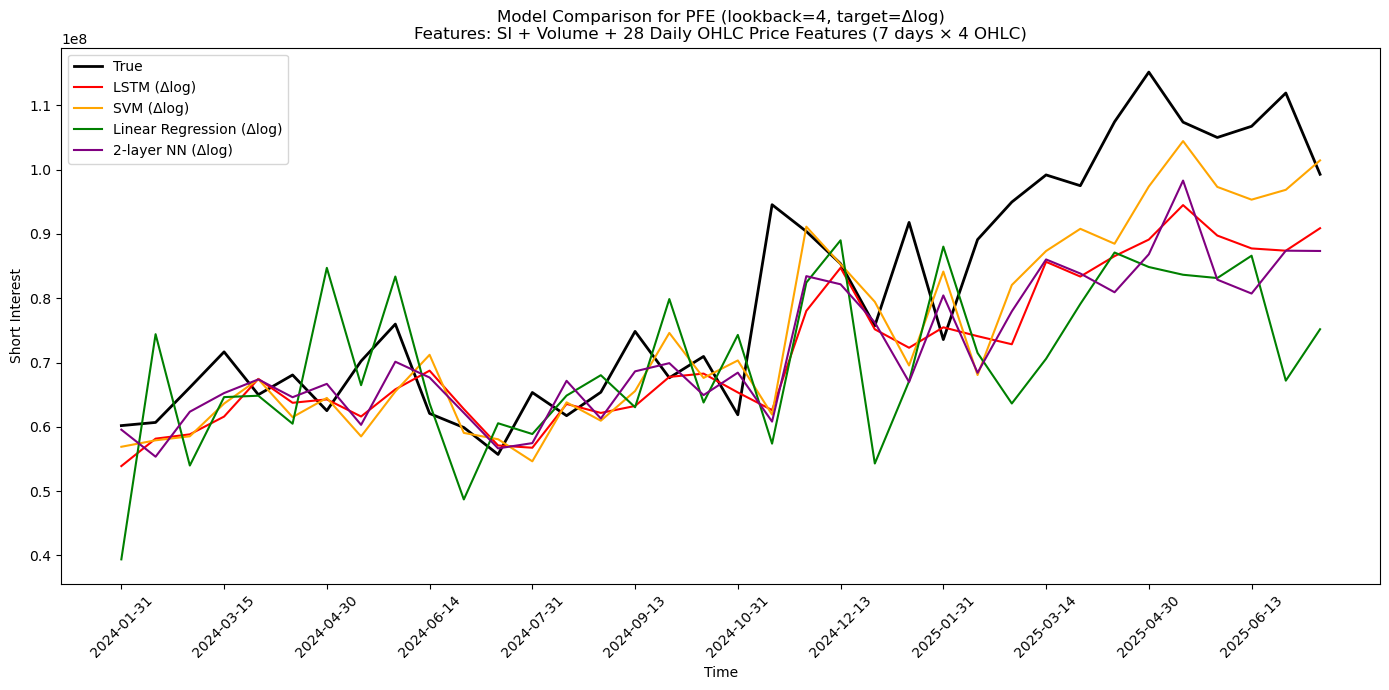


MODEL PERFORMANCE COMPARISON WITH OHLC FEATURES
            Model          MAE    MAPE         RMSE
              SVM 8.637166e+06 10.3377 1.114692e+07
             LSTM 9.849054e+06 11.1159 1.280381e+07
       2-layer NN 1.050739e+07 11.7702 1.389821e+07
Linear Regression 1.551961e+07 18.3124 1.877057e+07

Best performing model: SVM (MAPE: 10.34%)
LSTM rank: 1 out of 4
SVM vs Linear Regression: 43.5% improvement
LSTM vs Linear Regression: 39.3% improvement
2-layer NN vs Linear Regression: 35.7% improvement


In [132]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# -------------------------------------------------
# Assumes these already exist from your Δlog pipeline:
# X_train, X_test                # scaled inputs (N,L,30) windows
# y_train, y_test                # targets = Δlog(y) with shape (N,1)
# prev_log_test                  # np.array of log(y_{t-1}) for each X_test row, shape (N,)
# y_pred_levels (from LSTM)      # optional, if you already computed it
# SI_series                      # original level series (T,1)
# split, lookback_window         # same as before
# dates                          # index for plotting (use the SI series index)
# -------------------------------------------------

# Flatten inputs for sklearn (from 3D to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (N, lookback * 30)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)    # (N_test, lookback * 30)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")
print(f"Feature dimension per sample: {X_train_flat.shape[1]} (lookback={lookback_window} × features=30)")
print("Features: SI + Volume + 28 daily OHLC price features (4 OHLC × 7 days)")

# ---- SVM predicts Δlog ----
print("Training SVM...")
svm = SVR()
svm.fit(X_train_flat, y_train.ravel())
svm_logret  = svm.predict(X_test_flat)                 # r̂_t
svm_levels  = np.exp(prev_log_test + svm_logret)       # ŷ_t

# ---- Linear Regression predicts Δlog ----
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_flat, y_train.ravel())
lr_logret   = lr.predict(X_test_flat)
lr_levels   = np.exp(prev_log_test + lr_logret)

# ---- 2-layer MLP predicts Δlog ----
print("Training 2-layer MLP...")

# Define a simple 2-layer NN for regression
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_torch = SimpleMLP(X_train_flat.shape[1])
optimizer_mlp = torch.optim.Adam(mlp_torch.parameters(), lr=1e-3)
criterion_mlp = nn.SmoothL1Loss()

X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_flat, dtype=torch.float32)

# Train the model
epochs_mlp = 100
for epoch in range(epochs_mlp):
    mlp_torch.train()
    optimizer_mlp.zero_grad()
    output = mlp_torch(X_train_tensor)
    loss = criterion_mlp(output, y_train_tensor)
    loss.backward()
    optimizer_mlp.step()
    
    if epoch % 20 == 0:
        print(f"MLP Epoch {epoch+1}/{epochs_mlp}, Loss: {loss.item():.6f}")

# Predict
mlp_torch.eval()
with torch.no_grad():
    mlp_logret = mlp_torch(X_test_tensor).detach().numpy().ravel()
mlp_levels = np.exp(prev_log_test + mlp_logret)

# ---- LSTM levels (from your earlier step) ----
lstm_levels = y_pred_levels  # keep your variable name

# ---- True levels aligned to the test targets ----
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---- Plot test period only ----
dates = ticker_timeseries[stock]['SI'].dropna().index  # for x-ticks
plt.figure(figsize=(14,7))
test_idx = range(split + lookback_window, split + lookback_window + len(y_true_levels))
plt.plot(test_idx, y_true_levels, label='True', color='black', linewidth=2)
plt.plot(test_idx, lstm_levels, label='LSTM (Δlog)', color='red')
plt.plot(test_idx, svm_levels,  label='SVM (Δlog)', color='orange')
plt.plot(test_idx, lr_levels,   label='Linear Regression (Δlog)', color='green')
plt.plot(test_idx, mlp_levels,  label='2-layer NN (Δlog)', color='purple')

# Format x-axis with actual dates
if len(test_idx) <= 20:  # Only show date labels if not too many points
    plt.xticks(
        ticks=test_idx,
        labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)].strftime('%Y-%m-%d'),
        rotation=45
    )
else:
    # Show fewer date labels for better readability
    step = len(test_idx) // 10
    selected_idx = test_idx[::step]
    plt.xticks(
        ticks=selected_idx,
        labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)][::step].strftime('%Y-%m-%d'),
        rotation=45
    )

plt.title(f'Model Comparison for {stock} (lookback={lookback_window}, target=Δlog)\nFeatures: SI + Volume + 28 Daily OHLC Price Features (7 days × 4 OHLC)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Metrics on ORIGINAL LEVELS ----
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

results = []
for name, pred in [ 
    ("LSTM", lstm_levels),
    ("SVM", svm_levels),
    ("Linear Regression", lr_levels),
    ("2-layer NN", mlp_levels),
]:
    mae, mape, rmse = get_metrics(y_true_levels, pred)
    results.append({"Model": name, "MAE": mae, "MAPE": mape*100, "RMSE": rmse})

results_df = pd.DataFrame(results)
# Sort by MAPE (lower is better)
results_df = results_df.sort_values('MAPE')

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON WITH OHLC FEATURES")
print("="*60)
print(results_df.round(4).to_string(index=False))

# ---- Additional Analysis ----
print(f"\nBest performing model: {results_df.iloc[0]['Model']} (MAPE: {results_df.iloc[0]['MAPE']:.2f}%)")
print(f"LSTM rank: {results_df[results_df['Model'] == 'LSTM'].index[0] + 1} out of {len(results_df)}")

# Show improvement over linear baseline
lr_mape = results_df[results_df['Model'] == 'Linear Regression']['MAPE'].iloc[0]
for _, row in results_df.iterrows():
    if row['Model'] != 'Linear Regression':
        improvement = ((lr_mape - row['MAPE']) / lr_mape) * 100
        print(f"{row['Model']} vs Linear Regression: {improvement:.1f}% {'improvement' if improvement > 0 else 'worse'}")


In [7]:
# Save training and test data to pickle file for later usage
import pickle
import os

# Create cache directory if it doesn't exist
os.makedirs('cache', exist_ok=True)

# Prepare data dictionary with all relevant training and test data
data_to_save = {
    # Raw data
    'X_train_raw': X_train_raw,
    'X_test_raw': X_test_raw,
    'y_train': y_train,
    'y_test': y_test,
    
    # Dates
    'si_dates': si_dates,
    'SI_series': SI_series,

    'prev_log_test': prev_log_test,
    'prev_log_train': prev_log_train
}

# Save to pickle file
filename = f'cache/{stock}_training_data_with_ohlc.pkl'
with open(filename, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"Training and test data saved to: {filename}")


Training and test data saved to: cache/PFE_training_data_with_ohlc.pkl


In [11]:
data_to_save.keys()

dict_keys(['X_train_raw', 'X_test_raw', 'y_train', 'y_test', 'si_dates'])

In [12]:
data_to_save['si_dates']

DatetimeIndex(['2017-12-29', '2018-01-12', '2018-01-31', '2018-02-15',
               '2018-02-28', '2018-03-15', '2018-03-29', '2018-04-13',
               '2018-04-30', '2018-05-15',
               ...
               '2025-02-28', '2025-03-14', '2025-03-31', '2025-04-15',
               '2025-04-30', '2025-05-15', '2025-05-30', '2025-06-13',
               '2025-06-30', '2025-07-15'],
              dtype='datetime64[ns]', name='date', length=182, freq=None)